# Setting up

In [47]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
%cd /content/drive/MyDrive/Projects/1. Churn Prediction/

/content/drive/MyDrive/Projects/1. Churn Prediction


# Importing dataset

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [50]:
DATASET = "Trial 2: output_cleaned_dataset.csv"

In [51]:
df = pd.read_csv(DATASET)

In [52]:
df.shape

(6589, 41)

In [53]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.0,42.39,16.0,593.30,974.81,4498.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,10.69,10.0,542.40,610.28,31297.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,33.65,30.0,280.85,415.45,62069.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,27.82,4.0,1237.85,1599.51,46677.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.0,7.38,11.0,267.40,289.54,42853.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


# Cleaning dataset

## Splitting dataset into X and y

In [54]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [55]:
X.shape

(6589, 40)

In [56]:
y.shape

(6589,)

## Splitting dataset into train, test and val

In [57]:
# splitting into train (60%), test (20%) and val (20%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [58]:
X_train.shape

(4612, 40)

In [59]:
y_train.shape

(4612,)

In [60]:
X_test.shape

(988, 40)

In [61]:
y_test.shape

(988,)

In [62]:
X_val.shape

(989, 40)

In [63]:
y_val.shape

(989,)

# Testing out scalers

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

standard_scaler_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier())
])

minmax_scaler_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", RandomForestClassifier())
])

normalizer_pipeline = Pipeline([
    ("scaler", Normalizer()),
    ("classifier", RandomForestClassifier())
])

In [65]:
n = 1

In [66]:
# standard scaler baseline model
accs = []
for i in range(n):
  standard_scaler_model = standard_scaler_pipeline.fit(X_train, y_train)
  y_pred = standard_scaler_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.8491902834008097

In [67]:
# minmax scaler baseline model
accs = []
for i in range(n):
  minmax_scaler_model = minmax_scaler_pipeline.fit(X_train, y_train)
  y_pred = minmax_scaler_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.8421052631578947

In [68]:
# normalizer baseline model
accs = []
for i in range(n):
  normalizer_model = normalizer_pipeline.fit(X_train, y_train)
  y_pred = normalizer_model.predict(X_test)
  accs.append(accuracy_score(y_test, y_pred))
sum(accs) / len(accs)

0.8248987854251012

All 3 scalers seem to be producing more or less the same results.

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [70]:
X_train.shape

(4612, 40)

In [71]:
y_train.shape

(4612,)

In [72]:
X_test.shape

(988, 40)

In [73]:
y_test.shape

(988,)

# Training

## Building model

In [74]:
X_train[0].shape

(40,)

In [75]:
# building the model

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model = Sequential(layers=[
    Dense(1024, activation="relu", input_shape=(40,)),
    BatchNormalization(),
    Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2048, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

## Compiling and saving

In [76]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [77]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    "Trial 2: model3_weights.hdf5", 
    monitor="val_loss", 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    verbose=1
)

In [78]:
with open("Trial 2: model3.json", "w") as json_file:
  json_file.write(model.to_json())

## Fitting

In [79]:
history = model.fit(
    X_train, 
    y_train, 
    batch_size=16, 
    validation_data=(X_val, y_val), 
    verbose=1,
    callbacks=[checkpointer, earlystopping],
    shuffle=True,
    epochs=400
)

Epoch 1/400
280/289 [============================>.] - ETA: 0s - loss: 0.8403 - accuracy: 0.6440
Epoch 1: val_loss improved from inf to 384.92499, saving model to Trial 2: model3_weights.hdf5
289/289 [==============================] - 6s 10ms/step - loss: 0.8362 - accuracy: 0.6455 - val_loss: 384.9250 - val_accuracy: 0.6896
Epoch 2/400
287/289 [============================>.] - ETA: 0s - loss: 0.7040 - accuracy: 0.6977
Epoch 2: val_loss did not improve from 384.92499
289/289 [==============================] - 2s 6ms/step - loss: 0.7050 - accuracy: 0.6973 - val_loss: 726.2357 - val_accuracy: 0.6906
Epoch 3/400
289/289 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.7244
Epoch 3: val_loss improved from 384.92499 to 185.59924, saving model to Trial 2: model3_weights.hdf5
289/289 [==============================] - 2s 6ms/step - loss: 0.6504 - accuracy: 0.7244 - val_loss: 185.5992 - val_accuracy: 0.6764
Epoch 4/400
281/289 [============================>.] - ETA: 0s -

# Analysing

In [80]:
training_acc = history.history["accuracy"]
training_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

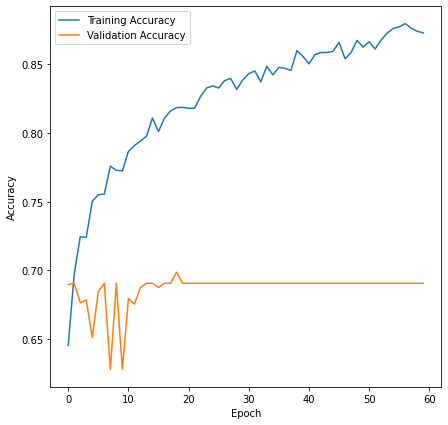

In [81]:
plt.figure(figsize=(7, 7))
plt.plot(history.epoch, training_acc, label="Training Accuracy")
plt.plot(history.epoch, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

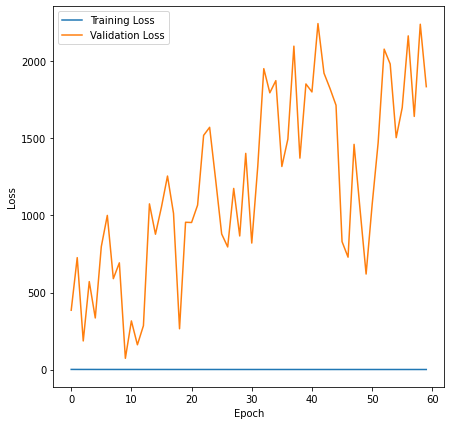

In [82]:
plt.figure(figsize=(7, 7))
plt.plot(history.epoch, training_loss, label="Training Loss")
plt.plot(history.epoch, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [83]:
y_pred = np.round(model.predict(X_test))

31/31 [==============================] - 0s 3ms/step


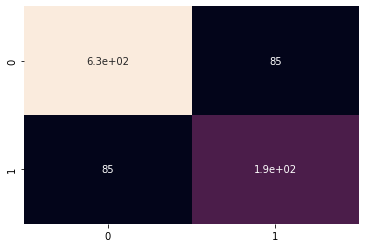

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

In [85]:
accuracy_score(y_test, y_pred)

0.8279352226720648

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       712
         1.0       0.69      0.69      0.69       276

    accuracy                           0.83       988
   macro avg       0.79      0.79      0.79       988
weighted avg       0.83      0.83      0.83       988



In [87]:
stayed_precision = precision_score(y_test, y_pred, labels=[0, 1], pos_label=0)

In [88]:
churned_precision = precision_score(y_test, y_pred, labels=[0, 1], pos_label=1)

In [89]:
stayed_recall = recall_score(y_test, y_pred, labels=[0, 1], pos_label=0)

In [90]:
churned_recall = recall_score(y_test, y_pred, labels=[0, 1], pos_label=1)

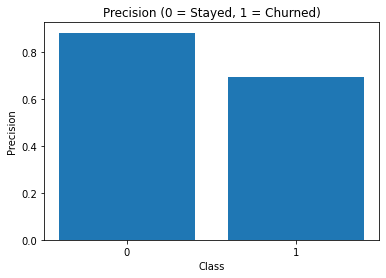

In [91]:
plt.bar(["0", "1"], [stayed_precision, churned_precision])
plt.xlabel("Class")
plt.ylabel("Precision")
plt.title("Precision (0 = Stayed, 1 = Churned)")
plt.show()

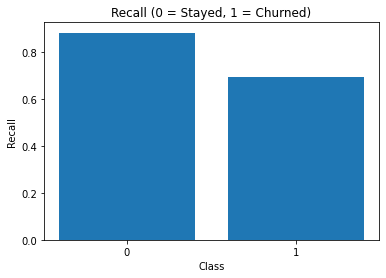

In [92]:
plt.bar(["0", "1"], [stayed_recall, churned_recall])
plt.xlabel("Class")
plt.ylabel("Recall")
plt.title("Recall (0 = Stayed, 1 = Churned)")
plt.show()